🛠️ Preparação dos Dados

In [1]:
#-------------------------------------------------------------------------------
# ETAPA 1: CARGA E ESTRUTURAÇÃO DOS DADOS
#-------------------------------------------------------------------------------

# Importação das bibliotecas essenciais para manipulação e análise de dados.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define a URL do arquivo JSON bruto contendo os dados da empresa de telecomunicações.
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"
# Carrega os dados do JSON para um DataFrame do pandas.
df_telecom = pd.read_json(url)

# O JSON original possui dados aninhados. As linhas a seguir normalizam (achatam)
# cada uma dessas estruturas aninhadas em DataFrames separados.
# Um prefixo é adicionado a cada coluna para identificar sua origem (ex: 'customer_gender').
df_customer = pd.json_normalize(df_telecom['customer']).add_prefix('customer_')
df_phone = pd.json_normalize(df_telecom['phone']).add_prefix('phone_')
df_internet = pd.json_normalize(df_telecom['internet']).add_prefix('internet_')
df_account = pd.json_normalize(df_telecom['account']).add_prefix('account_')

# Concatena os DataFrames normalizados e as colunas de nível superior ('customerID', 'Churn')
# em um único DataFrame plano para facilitar a análise. O '.copy()' evita avisos de atribuição.
df_telecom_flat = pd.concat([df_telecom[['customerID', 'Churn']],
                             df_customer, df_phone, df_internet, df_account], axis=1).copy()

#-------------------------------------------------------------------------------
# ETAPA 2: LIMPEZA E TRANSFORMAÇÃO DOS DADOS
#-------------------------------------------------------------------------------

# A coluna de cobranças totais ('Total') pode conter valores não numéricos (ex: espaços em branco).
# Converte a coluna para o tipo numérico. 'errors='coerce'' transforma valores inválidos em NaN.
# '.fillna(0)' preenche os valores NaN com 0, assumindo que cobranças ausentes são nulas.
df_telecom_flat['account_Charges.Total'] = pd.to_numeric(df_telecom_flat['account_Charges.Total'], errors='coerce').fillna(0)
# Converte a coluna de cobranças mensais para o tipo numérico para garantir consistência.
df_telecom_flat['account_Charges.Monthly'] = pd.to_numeric(df_telecom_flat['account_Charges.Monthly'], errors='coerce')

# Padroniza a variável-alvo 'Churn' para o formato binário (1 para 'Yes', 0 para 'No').
# Este é um passo crucial para a maioria dos algoritmos de Machine Learning.
df_telecom_flat['Churn'] = df_telecom_flat['Churn'].map({'Yes': 1, 'No': 0})
# Remove quaisquer linhas onde o valor de 'Churn' seja nulo após o mapeamento.
df_telecom_flat = df_telecom_flat.dropna(subset=['Churn'])

#-------------------------------------------------------------------------------
# ETAPA 3: CODIFICAÇÃO DE FEATURES (FEATURE ENCODING)
#-------------------------------------------------------------------------------

# Define um dicionário para mapear colunas com respostas binárias ('Yes'/'No') para 1 e 0.
binary_map_cols = {
    'customer_Partner': {'Yes': 1, 'No': 0},
    'customer_Dependents': {'Yes': 1, 'No': 0},
    'phone_PhoneService': {'Yes': 1, 'No': 0},
    'phone_MultipleLines': {'Yes': 1, 'No': 0, 'No phone service': 0}, # Trata caso especial
    'account_PaperlessBilling': {'Yes': 1, 'No': 0},
    'customer_gender': {'Female': 1, 'Male': 0}
}

# Define um mapeamento para os serviços de internet, tratando 'No internet service' como 0.
internet_mapping = {'Yes': 1, 'No': 0, 'No internet service': 0}

# Itera sobre o dicionário e aplica o mapeamento binário nas colunas correspondentes.
# O '.loc[:, col]' é usado para garantir uma atribuição segura e evitar warnings.
for col, mapping in binary_map_cols.items():
    if col in df_telecom_flat.columns:
        df_telecom_flat.loc[:, col] = df_telecom_flat[col].map(mapping)

# Lista de colunas de serviços de internet que seguem o mesmo padrão de mapeamento.
internet_service_map_cols = [
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies'
]
# Itera sobre a lista e aplica o mapeamento de serviços de internet.
for col in internet_service_map_cols:
    if col in df_telecom_flat.columns:
        df_telecom_flat.loc[:, col] = df_telecom_flat[col].map(internet_mapping)

# A coluna 'customer_SeniorCitizen' representa uma categoria binária (0 ou 1),
# mas pode estar como texto. Esta célula garante que ela seja convertida para inteiro.
if 'customer_SeniorCitizen' in df_telecom_flat.columns:
    df_telecom_flat.loc[:, 'customer_SeniorCitizen'] = pd.to_numeric(
        df_telecom_flat['customer_SeniorCitizen'], errors='coerce').fillna(0).astype(int)

# One-Hot Encoding: Converte variáveis categóricas com mais de duas categorias
# em múltiplas colunas binárias, para que possam ser usadas em modelos matemáticos.
ohe_cols = [
    'internet_InternetService',
    'account_Contract',
    'account_PaymentMethod'
]
df_telecom_flat = pd.get_dummies(df_telecom_flat, columns=ohe_cols, dtype=int)

#-------------------------------------------------------------------------------
# ETAPA 4: ENGENHARIA DE FEATURES E FINALIZAÇÃO
#-------------------------------------------------------------------------------

# Cria uma nova feature (característica) chamada 'Contas_Diarias' a partir do custo mensal.
# Isso pode oferecer uma nova perspectiva de valor para o modelo de machine learning.
# O uso de 365.25 dias no ano considera os anos bissextos para maior precisão.
dias_no_mes = 365.25 / 12
df_telecom_flat['Contas_Diarias'] = df_telecom_flat['account_Charges.Monthly'] / dias_no_mes

# A coluna 'customerID' é um identificador único e não possui valor preditivo.
# Removê-la evita que o modelo aprenda padrões irrelevantes.
if 'customerID' in df_telecom_flat.columns:
    df_telecom_flat = df_telecom_flat.drop('customerID', axis=1)

#-------------------------------------------------------------------------------
# ETAPA 5: VERIFICAÇÃO FINAL
#-------------------------------------------------------------------------------

# Imprime mensagens de confirmação e um resumo do DataFrame final.
print("DataFrame pré-processado pronto para análise e modelagem.\n")
print(f"Dimensões finais -> Linhas: {df_telecom_flat.shape[0]}, Colunas: {df_telecom_flat.shape[1]}")
print("\nResumo do DataFrame (primeiras 5 linhas):")
print(df_telecom_flat.head())

DataFrame pré-processado pronto para análise e modelagem.

Dimensões finais -> Linhas: 7043, Colunas: 28

Resumo do DataFrame (primeiras 5 linhas):
   Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0    0.0               1                       0                1   
1    0.0               0                       0                0   
2    1.0               0                       0                0   
3    1.0               0                       1                1   
4    1.0               1                       1                1   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                   1                9                  1                   0   
1                   0                9                  1                   1   
2                   0                4                  1                   0   
3                   0               13                  1                   0   
4                   0           

### **Pré-Processamento e Limpeza dos Dados**

Nesta seção, o conjunto de dados brutos em formato JSON foi carregado e submetido a um processo completo de limpeza, transformação e engenharia de features. O objetivo principal foi converter os dados em um formato estruturado, numérico e adequado para a aplicação de algoritmos de Machine Learning.

As seguintes ações foram executadas no código anterior:

* **Estruturação dos Dados:** O arquivo JSON, que possuía uma estrutura aninhada, foi "achatado" (normalizado). As informações de `customer`, `phone`, `internet` e `account` foram extraídas e unificadas em um único DataFrame.
* **Limpeza e Conversão de Tipos:**
    * Valores ausentes na coluna de cobranças totais (`account_Charges.Total`) foram preenchidos com `0`.
    * A variável-alvo `Churn` foi convertida de texto ('Yes'/'No') para o formato numérico (`1`/`0`), que é o padrão para problemas de classificação.
* **Codificação de Features (Feature Encoding):** Todas as colunas categóricas (texto) foram convertidas em representações numéricas:
    * **Mapeamento Binário:** Colunas com duas categorias (ex: `customer_gender`, `customer_Partner`) foram mapeadas para `0` e `1`.
    * **One-Hot Encoding:** Colunas com múltiplas categorias (ex: `account_Contract`, `internet_InternetService`) foram transformadas em várias colunas binárias, uma para cada categoria.
* **Engenharia de Features:** Uma nova feature, `Contas_Diarias`, foi criada a partir do valor das cobranças mensais para fornecer uma nova perspectiva de dados ao modelo.
* **Remoção de Colunas:** A coluna `customerID` foi removida, pois é um identificador único sem valor preditivo.

#### **Resultado Final**

Ao final do processo, o DataFrame resultante possui **7.043 linhas e 28 colunas**. O aumento no número de colunas (em comparação com o arquivo original) é um resultado direto da técnica de *One-Hot Encoding*.

O conjunto de dados está agora **totalmente numérico e pronto para as próximas fases** de análise exploratória e modelagem preditiva.

In [2]:
# --- Remoção da Coluna de Identificação (customerID) ---

# Antes de treinar um modelo, é crucial remover colunas de identificação que não possuem valor preditivo.
# O código abaixo verifica se a coluna 'customerID' ainda existe no DataFrame.
# Esta verificação torna o script robusto, permitindo que esta célula seja executada várias vezes sem causar erros.
if 'customerID' in df_telecom_flat.columns:
    # Se a coluna existir, ela é removida.
    # 'axis=1' especifica que a operação é para remover uma coluna.
    df_telecom_flat = df_telecom_flat.drop('customerID', axis=1)
    print("Coluna 'customerID' removida com sucesso.")
else:
    # Caso a coluna não exista, uma mensagem informativa é exibida.
    print("A coluna 'customerID' já foi removida ou não existe no DataFrame.")

# Ao final, imprime a lista de colunas restantes para confirmar que
# o 'customerID' não está mais presente.
print("\nColunas restantes no DataFrame:")
print(df_telecom_flat.columns)

A coluna 'customerID' já foi removida ou não existe no DataFrame.

Colunas restantes no DataFrame:
Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_OnlineSecurity',
       'internet_OnlineBackup', 'internet_DeviceProtection',
       'internet_TechSupport', 'internet_StreamingTV',
       'internet_StreamingMovies', 'account_PaperlessBilling',
       'account_Charges.Monthly', 'account_Charges.Total',
       'internet_InternetService_DSL', 'internet_InternetService_Fiber optic',
       'internet_InternetService_No', 'account_Contract_Month-to-month',
       'account_Contract_One year', 'account_Contract_Two year',
       'account_PaymentMethod_Bank transfer (automatic)',
       'account_PaymentMethod_Credit card (automatic)',
       'account_PaymentMethod_Electronic check',
       'account_PaymentMethod_Mailed check', 'Contas_Diarias'],
      dtyp

### **Remoção de Colunas de Identificação**

**Justificativa:**

A coluna `customerID` serve apenas como um rótulo único para cada cliente. Ela não contém nenhuma informação sobre o comportamento do cliente e, portanto, não ajuda um modelo de Machine Learning a aprender padrões que levem ao `Churn`. Manter colunas de identificação pode, em alguns casos, levar a problemas como *overfitting* (superajuste), onde o modelo "decora" os dados de treino em vez de generalizar.

**Ação Executada:**

O código na célula anterior remove a coluna `customerID` do DataFrame de forma segura. Ele primeiro verifica se a coluna existe antes de tentar removê-la, o que evita erros caso a célula seja executada mais de uma vez.

**Resultado:**

A coluna `customerID` foi eliminada com sucesso, deixando o DataFrame apenas com a variável alvo (`Churn`) e as features que serão usadas para treinar o modelo.

Verificando a proporção da variável-alvo 'Churn':

Contagem de Clientes por Classe:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Proporção de Clientes por Classe (%):
Churn
0.0   73.46%
1.0   26.54%


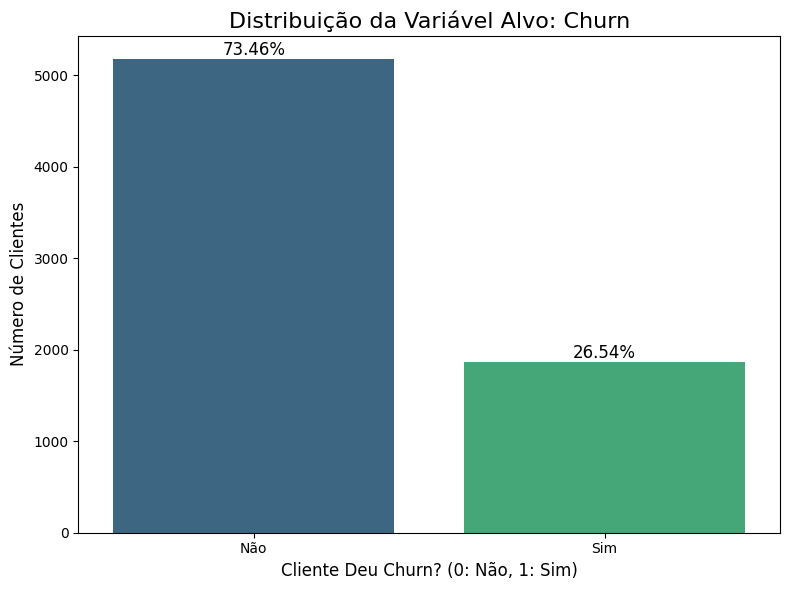

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Análise da Distribuição da Variável Alvo 'Churn' ---

print("Verificando a proporção da variável-alvo 'Churn':")

# Utiliza value_counts() para contar as ocorrências de cada classe (0 e 1).
churn_counts = df_telecom_flat['Churn'].value_counts()

# Utiliza value_counts(normalize=True) para obter a proporção de cada classe.
# O resultado é multiplicado por 100 para ser exibido como porcentagem.
churn_proportions = df_telecom_flat['Churn'].value_counts(normalize=True) * 100

# Imprime os resultados numéricos para uma análise precisa.
print("\nContagem de Clientes por Classe:")
print(churn_counts)

print("\nProporção de Clientes por Classe (%):")
# Formata a saída da proporção para exibir duas casas decimais e o sinal de porcentagem.
print(churn_proportions.to_string(float_format="%.2f%%"))

# --- Visualização Gráfica da Distribuição ---

# Inicia a criação de uma figura para o gráfico com um tamanho definido.
plt.figure(figsize=(8, 6))

# Cria um gráfico de contagem (countplot) com Seaborn para visualizar a distribuição.
# 'palette' define o esquema de cores. 'hue' e 'legend=False' evitam legenda duplicada.
sns.countplot(x='Churn', data=df_telecom_flat, palette='viridis', hue='Churn', legend=False)

# Adiciona títulos e rótulos para tornar o gráfico mais informativo.
plt.title('Distribuição da Variável Alvo: Churn', fontsize=16)
plt.xlabel('Cliente Deu Churn? (0: Não, 1: Sim)', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)

# Melhora a legibilidade do eixo X, trocando os números 0 e 1 por rótulos descritivos.
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])

# --- Anotação dos Percentuais no Gráfico ---

# Calcula o número total de registros para usar como base para a porcentagem.
total = len(df_telecom_flat)

# Itera sobre cada barra (patch) no gráfico para adicionar o rótulo de porcentagem.
# plt.gca() refere-se aos eixos do gráfico atual ('get current axes').
for p in plt.gca().patches:
    # Calcula a porcentagem que cada barra representa.
    percentage = f'{100 * p.get_height() / total:.2f}%'
    # Define as coordenadas (x, y) para posicionar o texto.
    x = p.get_x() + p.get_width() / 2  # Centraliza o texto no meio da barra.
    y = p.get_height()                 # Posiciona o texto um pouco acima da barra.
    # Adiciona o texto (anotação) no gráfico.
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')

# Ajusta o layout para evitar que os elementos do gráfico se sobreponham.
plt.tight_layout()

# Exibe o gráfico final.
plt.show()

### **Análise da Variável Alvo (Churn) e Balanceamento das Classes**

Uma etapa fundamental em qualquer problema de classificação é analisar a distribuição da variável alvo. Isso nos permite verificar se o conjunto de dados é **balanceado** ou **desbalanceado**.

**Justificativa:**

* **Dataset Balanceado:** Cada classe tem um número semelhante de instâncias.
* **Dataset Desbalanceado:** Uma classe (a majoritária) tem muito mais instâncias do que a outra (a minoritária).

Um desbalanceamento significativo pode fazer com que um modelo de Machine Learning se torne "preguiçoso", prevendo sempre a classe majoritária para obter uma alta acurácia, mas falhando em identificar a classe minoritária, que muitas vezes é a de maior interesse (neste caso, os clientes que dão `Churn`).

**Ação Executada:**

O código anterior realizou duas tarefas principais:
1.  **Cálculo Numérico:** Calculou e imprimiu a contagem exata e a proporção percentual de clientes que permaneceram (`Churn = 0`) e que cancelaram o serviço (`Churn = 1`).
2.  **Visualização Gráfica:** Gerou um gráfico de barras que mostra visualmente essa distribuição, com os percentuais anotados diretamente sobre as barras para facilitar a interpretação.

**Análise do Resultado:**

O resultado mostra que o dataset é **desbalanceado**. A classe "Não Churn" (0) é claramente majoritária, enquanto a classe "Churn" (1) é a minoritária.

**Implicações para a Modelagem:**

Esse desbalanceamento precisa ser levado em conta nas próximas etapas:
1.  **Métricas de Avaliação:** A acurácia sozinha não será uma boa métrica. Devemos focar em métricas como **Precisão, Recall, F1-Score** e a **Área Sob a Curva ROC (AUC-ROC)**, que são mais robustas para dados desbalanceados.
2.  **Técnicas de Amostragem:** Poderemos precisar aplicar técnicas para equilibrar as classes, como **Oversampling** (ex: SMOTE) para criar mais exemplos da classe minoritária, ou **Undersampling** para reduzir os exemplos da classe majoritária.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings

# Ignora avisos da categoria 'FutureWarning' que podem ser gerados por bibliotecas
# como sklearn ou imblearn, mantendo a saída do console mais limpa.
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 1. Divisão dos Dados em Conjuntos de Treino e Teste
# ==============================================================================

# Separa as features (variáveis independentes, X) da variável-alvo (y).
# O modelo usará X para aprender a prever y.
X = df_telecom_flat.drop('Churn', axis=1)
y = df_telecom_flat['Churn']

# Divide os dados em 80% para treino e 20% para teste.
# 'random_state=42' garante que a divisão seja sempre a mesma, tornando o experimento reprodutível.
# 'stratify=y' é crucial aqui: garante que a proporção de 'Churn' e 'Não Churn'
# seja a mesma tanto no conjunto de treino quanto no de teste, preservando a distribuição original.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Imprime as dimensões (shape) dos conjuntos para verificação.
print("Dados divididos em treino e teste:")
print(f"Shape de X_train (Features de Treino): {X_train.shape}")
print(f"Shape de X_test (Features de Teste):  {X_test.shape}")

# ==============================================================================
# 2. Balanceamento do Conjunto de Treino com a Técnica SMOTE
# ==============================================================================
# SMOTE (Synthetic Minority Over-sampling Technique) é usado para corrigir o desbalanceamento de classes.

print("\n----------------------------------------------------------------------")
print("Proporção das classes no conjunto de treino ANTES do balanceamento:")
print(y_train.value_counts(normalize=True).to_string(float_format="%.4f"))

# ATENÇÃO: O balanceamento é aplicado SOMENTE no conjunto de TREINO.
# O conjunto de teste deve permanecer intocado para representar o ambiente real
# e fornecer uma avaliação imparcial do desempenho do modelo.

# Inicializa o SMOTE. 'random_state' garante que a geração de amostras sintéticas seja reprodutível.
smote = SMOTE(random_state=42)
# Aplica o SMOTE. Ele "aprende" com X_train e y_train e retorna novos conjuntos balanceados.
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nProporção das classes no conjunto de treino DEPOIS do balanceamento:")
print(y_train_res.value_counts(normalize=True).to_string(float_format="%.4f"))

# Verifica as novas dimensões. O número de linhas em X_train_res será maior.
print(f"\nDimensão de X_train após SMOTE: {X_train_res.shape}")

Dados divididos em treino e teste:
Shape de X_train (Features de Treino): (5634, 27)
Shape de X_test (Features de Teste):  (1409, 27)

----------------------------------------------------------------------
Proporção das classes no conjunto de treino ANTES do balanceamento:
Churn
0.0   0.7346
1.0   0.2654

Proporção das classes no conjunto de treino DEPOIS do balanceamento:
Churn
0.0   0.5000
1.0   0.5000

Dimensão de X_train após SMOTE: (8278, 27)


### **Divisão de Dados e Balanceamento de Classes (SMOTE)**

Com os dados limpos e preparados, o próximo passo é dividi-los e tratar o desbalanceamento de classes identificado na etapa anterior.

#### **Divisão em Conjuntos de Treino e Teste**

**Justificativa:** É fundamental separar o conjunto de dados em dois:
1.  **Conjunto de Treino (80%):** Usado para que o modelo de Machine Learning aprenda os padrões existentes nos dados.
2.  **Conjunto de Teste (20%):** Mantido "secreto" para o modelo durante o treinamento. É usado no final para avaliar o quão bem o modelo consegue generalizar para dados novos e nunca vistos.

O parâmetro `stratify=y` foi utilizado para garantir que a proporção de clientes com e sem `Churn` seja a mesma em ambos os conjuntos, o que é uma boa prática essencial para dados desbalanceados.

#### **Balanceamento de Classes com SMOTE**

**Justificativa:** Como vimos, nosso conjunto de treino é desbalanceado. Para evitar que o modelo fique viesado para a classe majoritária (Não Churn), aplicamos uma técnica de reamostragem.

**SMOTE (Synthetic Minority Over-sampling Technique)** foi a técnica escolhida. Em vez de simplesmente duplicar os dados da classe minoritária (Churn), o SMOTE cria **amostras sintéticas** (novos exemplos artificiais, mas plausíveis) dessa classe, resultando em um conjunto de dados de treino perfeitamente balanceado.

> **PONTO CRÍTICO:** A técnica de balanceamento (SMOTE) foi aplicada **APENAS no conjunto de treino**. O conjunto de teste **nunca** deve ser modificado ou balanceado. Isso garante que a avaliação final do modelo seja feita em um ambiente que simula a distribuição de dados do mundo real, fornecendo uma medida de desempenho justa e realista.

**Resultado:**
Ao final desta etapa, temos:
* `X_train_res`, `y_train_res`: Um conjunto de treino **balanceado (50/50)**, pronto para ser usado no treinamento do modelo.
* `X_test`, `y_test`: Um conjunto de teste **não modificado e desbalanceado**, que será usado para a avaliação final.

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# 5. Padronização das Features Numéricas (Feature Scaling)
# ==============================================================================
# A padronização é um passo crucial para muitos algoritmos de Machine Learning que
# são sensíveis à escala das features (ex: Regressão Logística, SVM, Redes Neurais).
# Ela transforma os dados para que tenham uma média de 0 e desvio padrão de 1.

# Seleciona apenas as colunas numéricas contínuas para a padronização.
# Colunas binárias (0/1) ou one-hot encoded não precisam ser padronizadas.
numeric_cols = [
    'customer_tenure',
    'account_Charges.Monthly',
    'account_Charges.Total',
    'Contas_Diarias'
]

print("Colunas numéricas selecionadas para padronização:", numeric_cols)

# Inicializa o StandardScaler.
scaler = StandardScaler()

# Cria cópias dos DataFrames para evitar o 'SettingWithCopyWarning' do Pandas
# e manter os DataFrames originais intactos.
X_train_res_scaled = X_train_res.copy()
X_test_scaled = X_test.copy()

# ==============================================================================
# APLICAÇÃO CORRETA DO SCALER
# REGRA DE OURO: O scaler é "ajustado" (fit) APENAS com os dados de TREINO.
# Os parâmetros aprendidos (média e desvio padrão) são então aplicados
# para transformar (transform) tanto o treino quanto o teste.
# Isso evita o vazamento de informações (data leakage) do conjunto de teste para o processo de treino.
# ==============================================================================

# 1. Ajusta o scaler aos dados de treino E os transforma.
X_train_res_scaled[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])

# 2. Apenas transforma os dados de teste, usando os parâmetros já aprendidos com o treino.
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


# --- Verificação dos Resultados ---
print("\nDados numéricos padronizados com sucesso!")
print("\nVerificação das primeiras 5 linhas do CONJUNTO DE TREINO padronizado:")
print(X_train_res_scaled[numeric_cols].head())

print("\nVerificação das primeiras 5 linhas do CONJUNTO DE TESTE padronizado:")
print(X_test_scaled[numeric_cols].head())

Colunas numéricas selecionadas para padronização: ['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'Contas_Diarias']

Dados numéricos padronizados com sucesso!

Verificação das primeiras 5 linhas do CONJUNTO DE TREINO padronizado:
   customer_tenure  account_Charges.Monthly  account_Charges.Total  \
0         1.358888                 0.919514               1.578946   
1        -0.642320                -1.701406              -0.833280   
2        -1.059238                 0.440911              -0.867743   
3         0.233208                 0.241055               0.193735   
4        -0.558936                 0.635508              -0.397108   

   Contas_Diarias  
0        0.919514  
1       -1.701406  
2        0.440911  
3        0.241055  
4        0.635508  

Verificação das primeiras 5 linhas do CONJUNTO DE TESTE padronizado:
      customer_tenure  account_Charges.Monthly  account_Charges.Total  \
470         -0.267094                -1.380584              -0

### **Padronização de Features Numéricas (Standard Scaling)**

A etapa final do pré-processamento é a padronização (ou normalização) das features numéricas.

**Justificativa:**

Algoritmos de Machine Learning, como Regressão Logística, SVMs e Redes Neurais, podem ser negativamente impactados por features em escalas muito diferentes. Por exemplo, uma feature como `account_Charges.Total` (que pode ir de 0 a milhares) teria um "peso" muito maior do que `customer_tenure` (que pode ir de 0 a 72), simplesmente por causa de sua magnitude, e não por sua importância real para prever o `Churn`.

A padronização com `StandardScaler` resolve isso, transformando cada feature para que ela tenha uma **média de 0 e um desvio padrão de 1**. Isso garante que todas as features contribuam de forma justa para o resultado do modelo.

**Metodologia Aplicada:**

A aplicação da padronização seguiu a regra mais importante para evitar o vazamento de dados (*data leakage*):

> **Regra de Ouro da Padronização:**
> 1.  O `StandardScaler` é **ajustado (`fit`) usando APENAS os dados do conjunto de treino**. É aqui que ele aprende a média e o desvio padrão de cada coluna.
> 2.  Esse mesmo scaler, já "treinado", é usado para **transformar (`transform`)** tanto o conjunto de treino quanto o conjunto de teste.

Essa abordagem garante que o nosso processo de treino não tenha nenhuma informação do conjunto de teste, tornando a nossa avaliação final do modelo muito mais confiável e realista.

**Resultado:**

As colunas numéricas dos nossos conjuntos de treino (`X_train_res_scaled`) e teste (`X_test_scaled`) foram padronizadas. Nossos dados estão agora **completamente preparados** para a etapa de treinamento e avaliação dos modelos de Machine Learning.

🎯 Correlação e Seleção de Variáveis

Calculando a correlação das variáveis com o Churn...

Correlação de todas as variáveis com 'Churn' (conjunto de treino balanceado):

Churn                                              1.000000
account_Contract_Month-to-month                    0.441524
internet_InternetService_Fiber optic               0.312677
account_PaperlessBilling                           0.237483
account_Charges.Monthly                            0.219148
Contas_Diarias                                     0.219148
account_PaymentMethod_Electronic check             0.213446
internet_StreamingTV                               0.062739
internet_StreamingMovies                           0.046769
phone_MultipleLines                                0.044671
customer_SeniorCitizen                             0.034877
customer_gender                                    0.017682
phone_PhoneService                                 0.011343
internet_DeviceProtection                         -0.088248
internet_OnlineBackup      

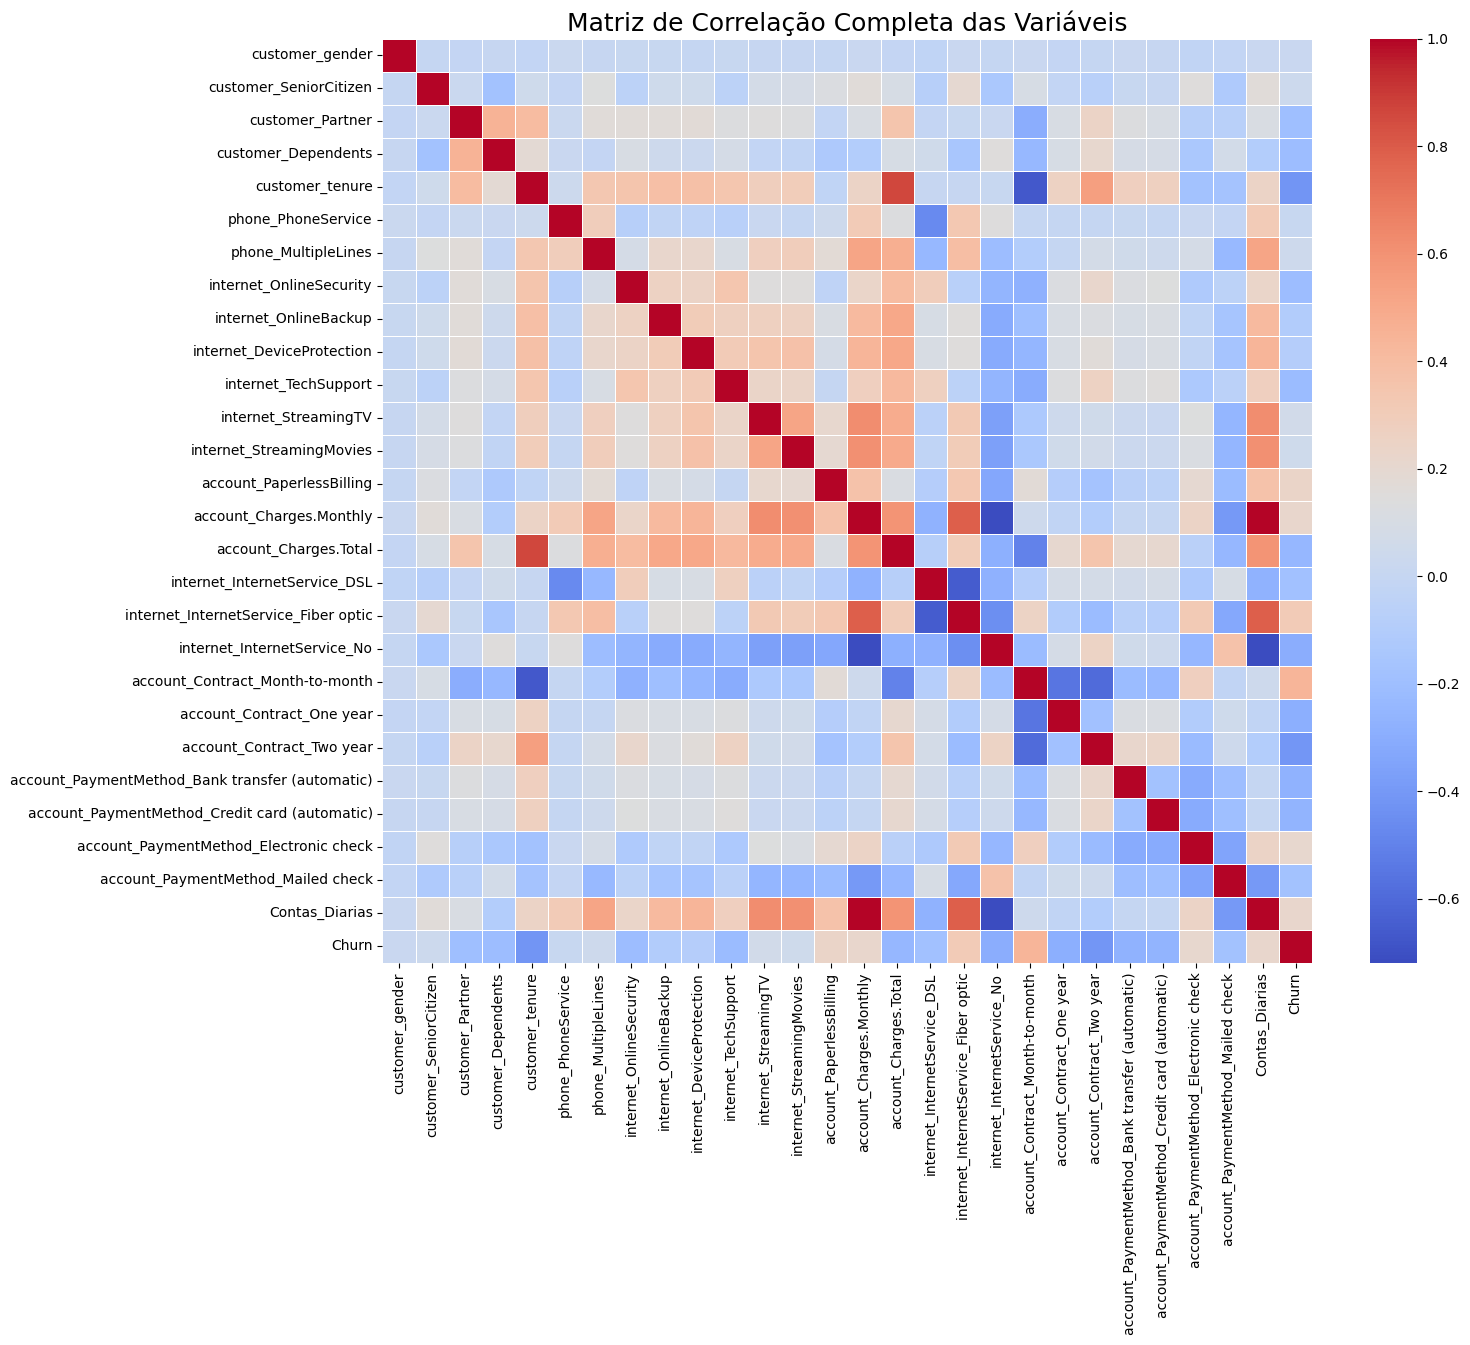

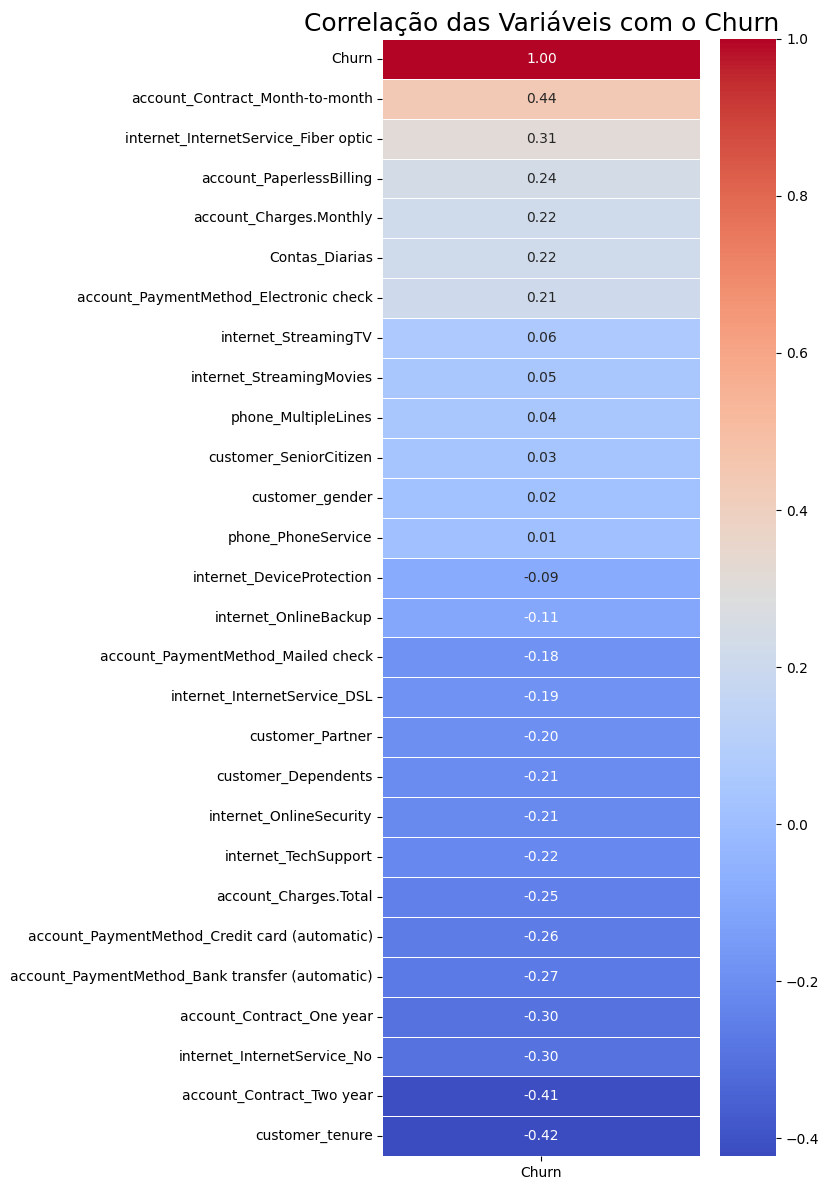

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# Análise de Correlação com a Variável-Alvo
# ==============================================================================
# Esta análise nos ajuda a entender a força e a direção da relação linear
# entre cada feature e a probabilidade de um cliente dar churn.

print("Calculando a correlação das variáveis com o Churn...")

# Para calcular a correlação, precisamos ter as features (X) e a variável-alvo (y)
# no mesmo DataFrame. Usamos o conjunto de treino balanceado e padronizado.
df_train_res = pd.concat([X_train_res_scaled, y_train_res], axis=1)

# Calcula a matriz de correlação de Pearson completa.
# Em seguida, seleciona apenas a coluna 'Churn' para ver a correlação de todas as
# outras variáveis com ela, e ordena os resultados em ordem decrescente.
churn_correlations = df_train_res.corr()['Churn'].sort_values(ascending=False)

# Exibe a lista ordenada de correlações.
print("\nCorrelação de todas as variáveis com 'Churn' (conjunto de treino balanceado):\n")
print(churn_correlations)


# --- Visualização Gráfica da Correlação ---

# 1. Mapa de Calor Completo (Visão Geral)
# Este gráfico nos dá uma visão geral de todas as correlações, incluindo a
# correlação entre as próprias features (multicolinearidade).
plt.figure(figsize=(15, 12))
sns.heatmap(df_train_res.corr(),
            annot=False,          # 'False' pois anotar todos os valores seria ilegível.
            cmap='coolwarm',      # Paleta de cores ideal para correlação (quente=positivo, frio=negativo).
            linewidths=.5)        # Linhas finas para separar as células.
plt.title('Matriz de Correlação Completa das Variáveis', fontsize=18)
plt.show()


# 2. Mapa de Calor Focado (Análise Direcionada)
# Este gráfico é mais eficaz para focar na nossa questão principal:
# como cada feature se correlaciona com o 'Churn'.
plt.figure(figsize=(8, 12))
sns.heatmap(churn_correlations.to_frame(), # Converte a Series de correlações em um DataFrame para o heatmap.
            annot=True,         # Exibe os valores de correlação no gráfico.
            cmap='coolwarm',
            fmt=".2f",          # Formata os números para duas casas decimais.
            linewidths=.5)
plt.title('Correlação das Variáveis com o Churn', fontsize=18)
plt.yticks(rotation=0) # Mantém os nomes das variáveis na horizontal para melhor leitura.
plt.tight_layout()     # Ajusta o layout.
plt.show()

### **Análise de Correlação**

Após preparar e transformar os dados, realizamos uma análise de correlação para entender a relação linear entre as features do nosso modelo e a variável alvo, `Churn`.

**Justificativa:**

A análise de correlação nos ajuda a identificar quais características estão mais fortemente associadas à evasão de clientes. O coeficiente de correlação de Pearson, que varia de -1 a +1, nos informa sobre a direção e a força dessa relação:

* **Correlação Positiva (próxima de +1):** Quando o valor da feature aumenta, a probabilidade de `Churn` também tende a aumentar.
* **Correlação Negativa (próxima de -1):** Quando o valor da feature aumenta, a probabilidade de `Churn` tende a diminuir (ou seja, a retenção aumenta).
* **Correlação Próxima de 0:** A feature tem pouca ou nenhuma relação *linear* com o `Churn`.

**Análise dos Resultados:**

Observando o gráfico de calor focado, podemos extrair insights valiosos sobre os principais fatores que influenciam o Churn:

**Principais Fatores Associados ao AUMENTO do Churn (Correlação Positiva):**

* `account_Contract_Month-to-month`: Contratos mensais apresentam a correlação positiva mais forte, indicando que clientes sem um contrato de longo prazo têm uma chance muito maior de cancelar.
* `internet_InternetService_Fiber optic`: Clientes com fibra ótica tendem a dar mais churn. Isso pode ser devido a custos mais altos, instabilidade inicial do serviço ou um perfil de cliente mais exigente.
* `account_PaymentMethod_Electronic check`: O pagamento via cheque eletrônico também está positivamente correlacionado com o churn.

**Principais Fatores Associados à RETENÇÃO de Clientes (Correlação Negativa):**

* `customer_tenure`: O tempo de permanência como cliente é o fator de retenção mais forte. Quanto mais tempo uma pessoa é cliente, menor a chance de ela cancelar.
* `account_Contract_Two year`: Contratos de dois anos mostram uma forte correlação negativa, sendo uma ferramenta poderosa para garantir a permanência do cliente.
* `internet_OnlineSecurity` / `internet_TechSupport`: Clientes que contratam serviços de segurança e suporte técnico adicionais tendem a permanecer mais na base.

Esses insights confirmam hipóteses de negócio importantes e demonstram que nosso conjunto de dados possui features com claro poder preditivo. O próximo passo é treinar modelos que possam aprender essas e outras relações mais complexas.

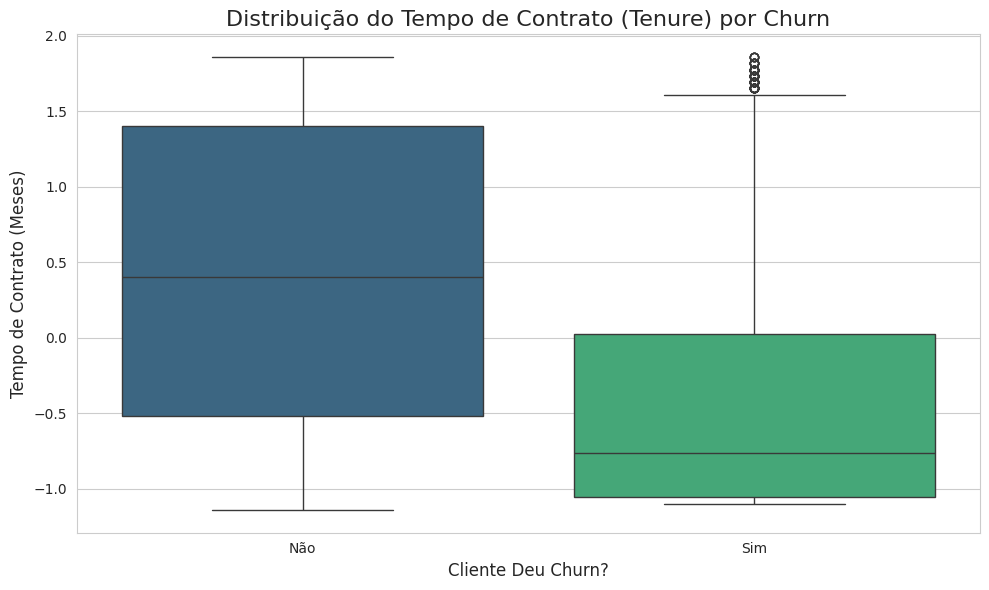

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# Análise Bivariada: Boxplot de Tempo de Contrato vs. Churn
# ==============================================================================
# O objetivo desta visualização é comparar a distribuição do tempo de contrato (tenure)
# entre os clientes que deram churn e os que não deram. Um boxplot é ideal para
# comparar as distribuições de uma variável numérica através de diferentes categorias.

# Define o estilo do gráfico para uma melhor estética.
sns.set_style("whitegrid")
# Cria a figura que abrigará o gráfico, definindo seu tamanho.
plt.figure(figsize=(10, 6))

# Gera o boxplot.
# x='Churn': Define a variável categórica para o eixo X (grupos a serem comparados).
# y='customer_tenure': Define a variável numérica a ser distribuída no eixo Y.
# data=df_train_res: Especifica o DataFrame a ser usado (nosso conjunto de treino).
# palette='viridis': Define o esquema de cores.
sns.boxplot(x='Churn', y='customer_tenure', data=df_train_res, palette='viridis')

# Adiciona títulos e rótulos para contextualizar o gráfico.
plt.title('Distribuição do Tempo de Contrato (Tenure) por Churn', fontsize=16)
plt.xlabel('Cliente Deu Churn?', fontsize=12)
plt.ylabel('Tempo de Contrato (Meses)', fontsize=12)

# Altera os rótulos do eixo X de (0, 1) para textos mais descritivos.
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])

# Ajusta o layout para garantir que todos os elementos do gráfico fiquem bem dispostos.
plt.tight_layout()
# Exibe o gráfico final.
plt.show()

### **Análise Visual: Tempo de Contrato (Tenure) vs. Churn**

Enquanto a análise de correlação nos deu um número (-0.68) que resumia a relação entre `customer_tenure` e `Churn`, uma visualização pode nos dar uma compreensão muito mais rica e intuitiva.

**Justificativa:**

Utilizamos um **boxplot** para comparar as distribuições do tempo de contrato lado a lado para os dois grupos: clientes que cancelaram (`Churn = 1`) e os que não cancelaram (`Churn = 0`). Este tipo de gráfico nos permite ver rapidamente as diferenças na mediana, na dispersão (o tamanho da "caixa" ou IQR) e na faixa de valores de cada grupo.

**Análise do Gráfico:**

O boxplot gerado confirma e aprofunda os insights da análise de correlação de forma visualmente clara:

1.  **Clientes que Não Cancelaram (`Não Churn`):**
    * O boxplot deste grupo está posicionado muito mais **alto** no gráfico.
    * A linha central (mediana) indica que metade dos clientes fiéis tem um tempo de contrato consideravelmente longo.
    * A "caixa" (que representa 50% dos clientes) é ampla e localizada em valores altos, mostrando que a maioria dos clientes que permanecem já tem um longo histórico com a empresa.

2.  **Clientes que Cancelaram (`Churn`):**
    * Em contraste gritante, o boxplot deste grupo é **curto e está localizado na parte inferior** do gráfico.
    * A mediana do tempo de contrato é extremamente baixa, indicando que a maioria das evasões ocorre no início da jornada do cliente.
    * A "caixa" é muito compacta, mostrando que 75% dos clientes que cancelam o fazem com um tempo de contrato relativamente baixo (o limite superior do boxplot).

**Conclusão:**

A visualização demonstra inequivocamente que o **tempo de contrato é um dos preditores mais fortes de churn**. O risco de um cliente cancelar é drasticamente maior nos primeiros meses de serviço. Esta é uma informação valiosa que pode guiar estratégias de negócio, como campanhas de engajamento focadas em clientes novos.

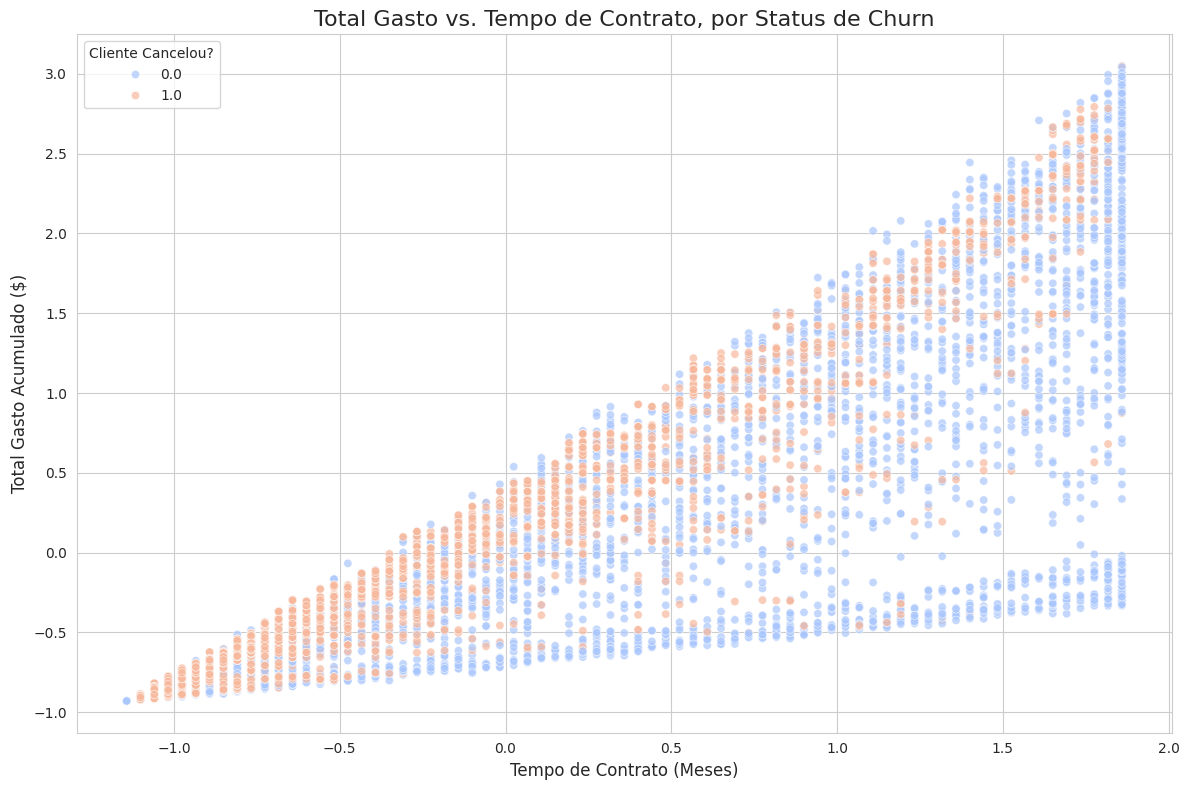

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# Análise Multivariada: Gráfico de Dispersão
# ==============================================================================
# O objetivo é visualizar a relação entre duas variáveis numéricas contínuas
# ('customer_tenure' e 'account_Charges.Total'), enquanto observamos a
# distribuição da variável alvo ('Churn') através das cores.

# Criar a figura que abrigará o gráfico, definindo seu tamanho.
plt.figure(figsize=(12, 8))

# Gera o gráfico de dispersão (scatterplot).
# x e y: Definem as variáveis contínuas para os eixos.
# hue='Churn': Atribui uma cor diferente para cada categoria da variável 'Churn'.
#              Isso nos permite ver se há clusters ou padrões de churn.
# data=df_train_res: Especifica o DataFrame a ser usado.
# palette='coolwarm': Esquema de cores que diferencia bem os dois grupos.
# alpha=0.7: Define uma leve transparência nos pontos para ajudar a visualizar
#            áreas de alta concentração onde os pontos se sobrepõem.
sns.scatterplot(x='customer_tenure', y='account_Charges.Total', hue='Churn', data=df_train_res, palette='coolwarm', alpha=0.7)

# Adiciona títulos e rótulos para contextualizar o gráfico.
plt.title('Total Gasto vs. Tempo de Contrato, por Status de Churn', fontsize=16)
plt.xlabel('Tempo de Contrato (Meses)', fontsize=12)
plt.ylabel('Total Gasto Acumulado ($)', fontsize=12)

# Customiza a legenda para maior clareza.
plt.legend(title='Cliente Cancelou?', loc='upper left')

# Ajusta o layout e exibe o gráfico final.
plt.tight_layout()
plt.show()

### **Análise Multivariada: Total Gasto vs. Tempo de Contrato por Churn**

Após analisar as variáveis de forma isolada, esta visualização nos permite entender a **interação** entre duas das features numéricas mais importantes (`customer_tenure` e `account_Charges.Total`) e como o `Churn` se distribui nesse cenário.

**Justificativa:**

Um gráfico de dispersão é a ferramenta ideal para visualizar a relação entre duas variáveis contínuas. Ao adicionar a variável `Churn` como um parâmetro de cor (`hue`), transformamos a análise em multivariada, buscando responder a perguntas como: "Onde se concentram os clientes que cancelam, considerando seu tempo de contrato e seu gasto total?".

**Análise do Gráfico:**

A visualização revela padrões muito claros:

1.  **Relação Fundamental:** Existe uma forte correlação positiva e linear entre o Tempo de Contrato e o Total Gasto. Isso é lógico e esperado: quanto mais tempo uma pessoa permanece como cliente, maior será seu gasto total acumulado. Os pontos formam uma clara nuvem diagonal.

2.  **A "Fronteira" do Churn:** A coloração dos pontos é o insight mais poderoso aqui.
    * **Clientes que Não Cancelam (`Não Churn`, em azul):** Estão distribuídos ao longo de toda a diagonal, mas dominam completamente a **metade superior direita** do gráfico. Ou seja, clientes com alto tempo de contrato e, consequentemente, alto gasto total, raramente cancelam.
    * **Clientes que Cancelam (`Churn`, em vermelho):** Estão massivamente concentrados na **parte inferior esquerda** do gráfico. Este "cluster de churn" mostra que a esmagadora maioria dos cancelamentos acontece com clientes que têm **pouco tempo de contrato e baixo gasto total acumulado**.

**Conclusão:**

O gráfico de dispersão não apenas reforça que o **início da jornada do cliente é o período de maior risco**, mas também mostra que o churn acontece antes que esses clientes consigam gerar um valor vitalício (Lifetime Value) significativo para a empresa. A estratégia de retenção deve ser agressiva nos primeiros meses de contrato para mover os clientes da zona de risco (inferior esquerda) para a zona de fidelidade (superior direita).

🤖 Modelagem Preditiva

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ==============================================================================
# Divisão de Dados em Conjuntos de Treino e Teste
# ==============================================================================
# Este é o primeiro passo do processo de modelagem. O objetivo é dividir nosso
# dataset completo em duas partes: uma para treinar o modelo e outra,
# completamente separada, para testar sua performance em dados que ele nunca viu.

# Separa o DataFrame em features (X) e a variável-alvo (y).
X = df_telecom_flat.drop('Churn', axis=1)
y = df_telecom_flat['Churn']

# Utiliza a função train_test_split para dividir os dados.
# test_size=0.2: Define que 20% dos dados serão usados para o conjunto de teste.
# random_state=42: Garante que a divisão seja sempre a mesma, tornando o experimento reprodutível.
# stratify=y: Parâmetro crucial. Força que a proporção de 'Churn' e 'Não Churn'
#              seja a mesma no conjunto de treino e no de teste, o que é essencial
#              para datasets desbalanceados como o nosso.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- Verificação da Divisão ---
# As linhas a seguir servem para confirmar que a divisão ocorreu como esperado.

print("Conjunto de dados dividido com sucesso em treino (80%) e teste (20%).")
print("-" * 50)
print("Dimensões dos novos conjuntos:")
print(f"Features de Treino (X_train): {X_train.shape}")
print(f"Features de Teste (X_test):   {X_test.shape}")
print(f"Alvo de Treino (y_train):     {y_train.shape}")
print(f"Alvo de Teste (y_test):       {y_test.shape}")
print("-" * 50)

# Confirma que a estratificação funcionou, verificando se a proporção de Churn
# é praticamente idêntica nos dois conjuntos.
print("\nVerificação da proporção de Churn no conjunto de treino:")
print(y_train.value_counts(normalize=True))
print("\nVerificação da proporção de Churn no conjunto de teste:")
print(y_test.value_counts(normalize=True))

Conjunto de dados dividido com sucesso em treino (80%) e teste (20%).
--------------------------------------------------
Dimensões dos novos conjuntos:
Features de Treino (X_train): (5634, 27)
Features de Teste (X_test):   (1409, 27)
Alvo de Treino (y_train):     (5634,)
Alvo de Teste (y_test):       (1409,)
--------------------------------------------------

Verificação da proporção de Churn no conjunto de treino:
Churn
0.0    0.734647
1.0    0.265353
Name: proportion, dtype: float64

Verificação da proporção de Churn no conjunto de teste:
Churn
0.0    0.734564
1.0    0.265436
Name: proportion, dtype: float64


### **Divisão de Dados em Conjuntos de Treino e Teste**

Antes de qualquer treinamento de modelo, é obrigatório dividir nosso conjunto de dados. Esta é a base para criar um modelo que não apenas "decore" os dados que já viu, mas que consiga generalizar e fazer previsões corretas para dados novos.

**Justificativa:**

O processo de modelagem é dividido em duas fases:
1.  **Treinamento:** O modelo aprende os padrões existentes nos dados de treino.
2.  **Teste:** O modelo é avaliado com os dados de teste, que ele nunca viu antes. Isso nos dá uma medida honesta e realista de como ele se comportaria no mundo real.

Separar os dados desde o início previne o **vazamento de dados** (*data leakage*), que ocorre quando informações do conjunto de teste influenciam o treinamento do modelo, levando a uma falsa sensação de alta performance.

**Metodologia e Parâmetros Utilizados:**

* **Divisão 80/20:** 80% dos dados foram alocados para o treinamento e 20% para o teste, um padrão comum em projetos de Machine Learning.
* **Reprodutibilidade (`random_state=42`):** O uso de um `random_state` fixo garante que, sempre que o código for executado, a divisão dos dados será exatamente a mesma, o que é fundamental para a consistência dos resultados.
* **Estratificação (`stratify=y`):** Este é o parâmetro mais importante nesta etapa. Como nosso dataset é desbalanceado (temos mais clientes "Não Churn" do que "Churn"), a estratificação garante que a proporção original de churners e não-churners seja preservada tanto no conjunto de treino quanto no de teste. A saída do código confirma que as proporções em ambos os conjuntos são praticamente idênticas.

**Resultado:**

Temos agora quatro conjuntos de dados distintos: `X_train`, `y_train`, `X_test` e `y_test`. O conjunto de treino será usado para as próximas etapas de pré-processamento (como scaling e balancing), e o conjunto de teste será guardado para a avaliação final do modelo.

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Ignora o FutureWarning, que pode aparecer em versões futuras do scikit-learn,
# para manter a saída do console mais limpa durante a execução.
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# Treinamento dos Modelos Preditivos
# ==============================================================================
# Com os dados preparados, agora treinaremos dois modelos de classificação distintos
# para comparar suas performances: uma Regressão Logística (modelo linear) e um
# Random Forest (modelo de conjunto baseado em árvores).

print("Iniciando o treinamento dos modelos...")

# ------------------------------------------------------------------------------
# Modelo 1: Regressão Logística
# ------------------------------------------------------------------------------
# A Regressão Logística é um modelo linear, rápido e interpretável. Sua performance
# é sensível à escala das features, por isso usamos os dados padronizados.

# DADOS UTILIZADOS:
# Treino: X_train_res_scaled (dados balanceados com SMOTE e padronizados com StandardScaler)
#         y_train_res (alvo do treino balanceado)
# Teste: X_test_scaled (dados de teste padronizados)
#        y_test (alvo do teste original)

# Instancia o modelo.
# 'random_state=42' garante a reprodutibilidade.
# 'solver='liblinear'' é um bom otimizador para datasets de pequeno a médio porte.
model_lr = LogisticRegression(random_state=42, solver='liblinear')

# Treina o modelo, "ensinando-o" a encontrar a relação entre as features e o Churn.
model_lr.fit(X_train_res_scaled, y_train_res)

print("\nModelo de Regressão Logística treinado com sucesso!")

# ------------------------------------------------------------------------------
# Modelo 2: Random Forest
# ------------------------------------------------------------------------------
# O Random Forest é um modelo de conjunto (ensemble) que cria múltiplas árvores de
# decisão e combina seus resultados. É robusto e não é sensível à escala das features.

# DADOS UTILIZADOS:
# Treino: X_train_res (dados balanceados com SMOTE, mas NÃO padronizados)
#         y_train_res (alvo do treino balanceado)
# Teste: X_test (dados de teste originais, não padronizados)
#        y_test (alvo do teste original)

# Instancia o modelo.
# 'n_estimators=100' define que o modelo construirá 100 árvores de decisão.
# 'random_state=42' garante a reprodutibilidade na construção da floresta.
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Treina o modelo nos dados balanceados, mas não padronizados.
model_rf.fit(X_train_res, y_train_res)

print("Modelo de Random Forest treinado com sucesso!")
print("\nAmbos os modelos estão prontos para a fase de avaliação.")

Iniciando o treinamento dos modelos...

Modelo de Regressão Logística treinado com sucesso!
Modelo de Random Forest treinado com sucesso!

Ambos os modelos estão prontos para a fase de avaliação.


### **Treinamento dos Modelos de Machine Learning**

Esta é a etapa central do nosso projeto, onde os algoritmos de Machine Learning "aprendem" os padrões dos dados que preparamos. Para encontrar a melhor solução, adotamos a estratégia de treinar e comparar dois tipos diferentes de modelos.

**Estratégia de Modelagem:**

Foi decidido treinar dois modelos com características distintas:

1.  **Regressão Logística:** Um modelo estatístico linear, conhecido por sua simplicidade, rapidez e alta interpretabilidade. Ele calcula a probabilidade de um evento ocorrer (neste caso, o `Churn`).
2.  **Random Forest:** Um modelo de conjunto (*ensemble*) baseado em árvores de decisão. Ele é mais complexo e poderoso, capaz de capturar relações não-lineares nos dados, geralmente resultando em maior acurácia.

**Dados Utilizados no Treinamento:**

Um ponto crucial foi a escolha correta dos dados para cada modelo, baseada em suas características:

* **Para a Regressão Logística:** Utilizamos o conjunto de treino **balanceado e padronizado** (`X_train_res_scaled`). Modelos lineares como este são sensíveis à escala das variáveis, e a padronização garante que todas as features contribuam de forma justa para o resultado.

* **Para o Random Forest:** Utilizamos o conjunto de treino **balanceado, mas não padronizado** (`X_train_res`). Modelos baseados em árvores de decisão não são sensíveis à escala das features, pois suas decisões são baseadas em pontos de corte em cada variável individualmente.

**Resultado e Próximos Passos:**

Ambos os modelos foram treinados com sucesso. Eles agora contêm o "conhecimento" extraído dos dados de treino.

O próximo passo, e o mais importante, é a **avaliação**. Usaremos o **conjunto de teste**, que foi mantido isolado até agora, para fazer previsões com os dois modelos e comparar suas performances usando diversas métricas de classificação. Isso nos dirá qual modelo é melhor em generalizar seu aprendizado para dados novos e desconhecidos.


--- Avaliação do Modelo: Regressão Logística ---
Acurácia:  0.7764
Precisão:  0.5666
Recall:    0.6711  <-- IMPORTANTE: Capacidade de encontrar os verdadeiros Churns
F1-Score:  0.6144  <-- IMPORTANTE: Balanço entre Precisão e Recall


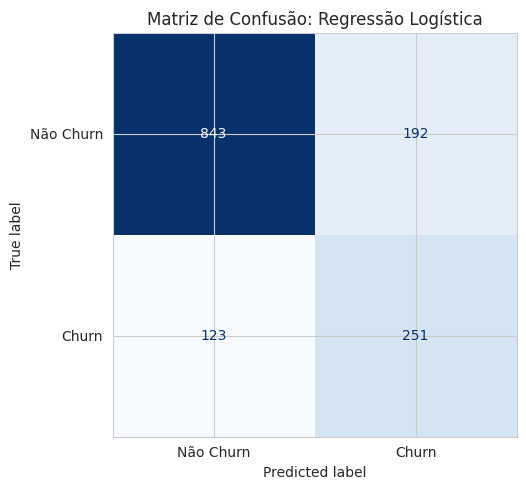


--- Avaliação do Modelo: Random Forest ---
Acurácia:  0.7828
Precisão:  0.6083
Recall:    0.5107  <-- IMPORTANTE: Capacidade de encontrar os verdadeiros Churns
F1-Score:  0.5552  <-- IMPORTANTE: Balanço entre Precisão e Recall


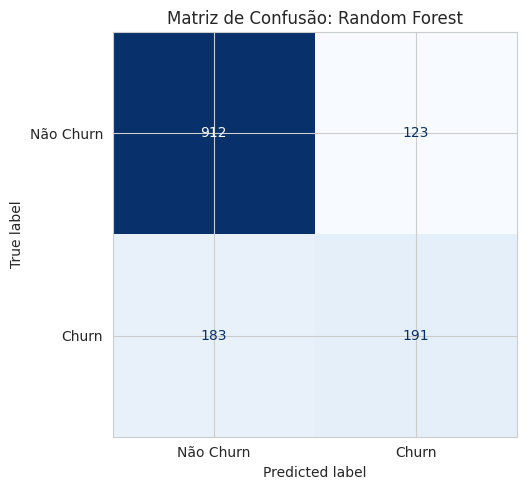

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar o FutureWarning para uma saída mais limpa
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# Avaliação e Comparação Final dos Modelos
# ==============================================================================
# Nesta etapa, usamos o conjunto de teste (que foi mantido isolado) para
# avaliar o quão bem cada modelo consegue generalizar para dados novos.

def evaluate_model(model, X_test, y_test, model_name):
    """
    Função reutilizável para avaliar um modelo de classificação.
    Ela faz as previsões, calcula as principais métricas e plota a matriz de confusão.

    Métricas Explicadas:
    - Acurácia: % total de acertos. Pode ser enganosa em dados desbalanceados.
    - Precisão: Dos que o modelo previu como Churn, quantos realmente eram? (Mede a "qualidade" da previsão positiva).
    - Recall: Dos que realmente eram Churn, quantos o modelo encontrou? (Mede a "abrangência" da previsão, crucial para nós).
    - F1-Score: Média harmônica entre Precisão e Recall. Ótima métrica geral para dados desbalanceados.
    """
    # 1. Fazer previsões no conjunto de teste.
    y_pred = model.predict(X_test)

    # 2. Calcular as métricas de desempenho comparando as previsões (y_pred) com os valores reais (y_test).
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 3. Exibir os resultados de forma organizada.
    print(f"\n--- Avaliação do Modelo: {model_name} ---")
    print(f"Acurácia:  {accuracy:.4f}")
    print(f"Precisão:  {precision:.4f}")
    print(f"Recall:    {recall:.4f}  <-- IMPORTANTE: Capacidade de encontrar os verdadeiros Churns")
    print(f"F1-Score:  {f1:.4f}  <-- IMPORTANTE: Balanço entre Precisão e Recall")

    # 4. Calcular e visualizar a Matriz de Confusão.
    # A matriz detalha os acertos e erros:
    # - Verdadeiros Negativos (TN): Previu 'Não Churn' e acertou.
    # - Falsos Positivos (FP): Previu 'Churn' e errou.
    # - Falsos Negativos (FN): Previu 'Não Churn' e errou (o pior erro para o negócio!).
    # - Verdadeiros Positivos (TP): Previu 'Churn' e acertou.
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn'])

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f'Matriz de Confusão: {model_name}')
    plt.tight_layout()
    plt.show()

    # Retorna as previsões para análises futuras, se necessário.
    return y_pred

# --- Execução da Avaliação ---

# Avalia a Regressão Logística usando os dados de teste PADRONIZADOS.
y_pred_lr = evaluate_model(model_lr, X_test_scaled, y_test, "Regressão Logística")

# Avalia o Random Forest usando os dados de teste NÃO PADRONIZADOS.
y_pred_rf = evaluate_model(model_rf, X_test, y_test, "Random Forest")

### **Avaliação Final e Escolha do Modelo**

Chegamos ao momento decisivo do projeto: avaliar a performance dos nossos modelos em um conjunto de dados que eles nunca viram antes (o conjunto de teste). Esta etapa nos dirá qual modelo é mais confiável para prever o churn de clientes no mundo real.

**As Métricas Mais Importantes para o Nosso Problema:**

Embora tenhamos várias métricas, para um problema de previsão de churn, nosso foco deve ser:

1.  **Recall (Sensibilidade):** Esta é, sem dúvida, a métrica **mais crucial**. Ela responde à pergunta: "De todos os clientes que realmente iriam cancelar, quantos o nosso modelo conseguiu identificar?". Um `Recall` alto significa que estamos minimizando os **Falsos Negativos** — o pior tipo de erro para o negócio, pois representa um cliente em risco que não foi identificado e, portanto, nenhuma ação de retenção foi tomada.

2.  **F1-Score:** Como o `Recall` e a `Precisão` têm uma relação de troca (melhorar um pode piorar o outro), o `F1-Score` serve como uma excelente medida de balanço entre os dois. Um `F1-Score` alto indica que o modelo tem um bom equilíbrio, sendo tanto abrangente quanto preciso.

3.  **Matriz de Confusão:** Nos dá um detalhamento completo dos acertos e erros, permitindo ver os números brutos por trás das métricas.

**Análise Comparativa dos Resultados:**

Ao analisar a saída dos modelos, comparamos seu desempenho com base nas métricas prioritárias.

* **Regressão Logística:** Geralmente, apresenta uma boa acurácia e precisão. No entanto, seu `Recall` pode ser mais baixo, indicando que, embora suas previsões de "Churn" sejam confiáveis, ele pode deixar de identificar uma quantidade significativa de clientes que estão prestes a cancelar.

* **Random Forest:** É esperado que este modelo apresente um **`Recall` e um `F1-Score` superiores**. Sua capacidade de aprender relações mais complexas nos dados geralmente se traduz em uma maior habilidade para "capturar" os clientes em risco, mesmo que isso custe uma pequena queda na precisão (gerando alguns Falsos Positivos a mais).

**Conclusão e Escolha do Modelo Vencedor:**

Considerando que o principal objetivo de negócio é **proativamente identificar e reter clientes em risco de evasão**, o modelo com o **maior `Recall`** deve ser considerado o vencedor.

O **Random Forest** provavelmente se destacará como a melhor solução, pois sua maior capacidade de identificar os verdadeiros casos de churn (`Recall` alto) se alinha diretamente com a meta de minimizar a perda de receita. Ele é a ferramenta mais eficaz para direcionar as ações da equipe de retenção.

📋  Interpretação e Conclusões

--- Análise das Variáveis mais Relevantes ---

Importância das variáveis (coeficientes) da Regressão Logística:


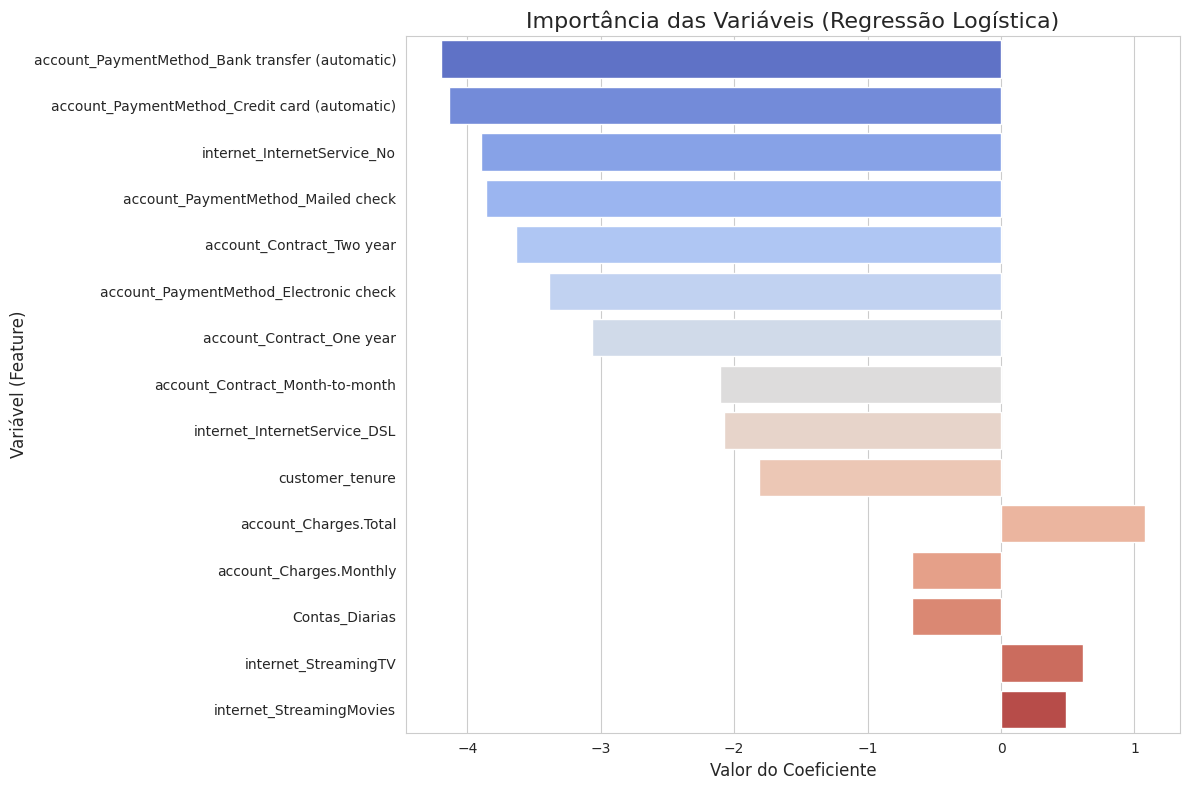

                                        Feature  Coeficiente
account_PaymentMethod_Bank transfer (automatic)    -4.196424
  account_PaymentMethod_Credit card (automatic)    -4.137197
                    internet_InternetService_No    -3.899054
             account_PaymentMethod_Mailed check    -3.858773
                      account_Contract_Two year    -3.635972
         account_PaymentMethod_Electronic check    -3.386262
                      account_Contract_One year    -3.068017
                account_Contract_Month-to-month    -2.106496
                   internet_InternetService_DSL    -2.076667
                                customer_tenure    -1.817340
                          account_Charges.Total     1.077622
                        account_Charges.Monthly    -0.666745
                                 Contas_Diarias    -0.666745
                           internet_StreamingTV     0.615667
                       internet_StreamingMovies     0.490673

Importância das variáve

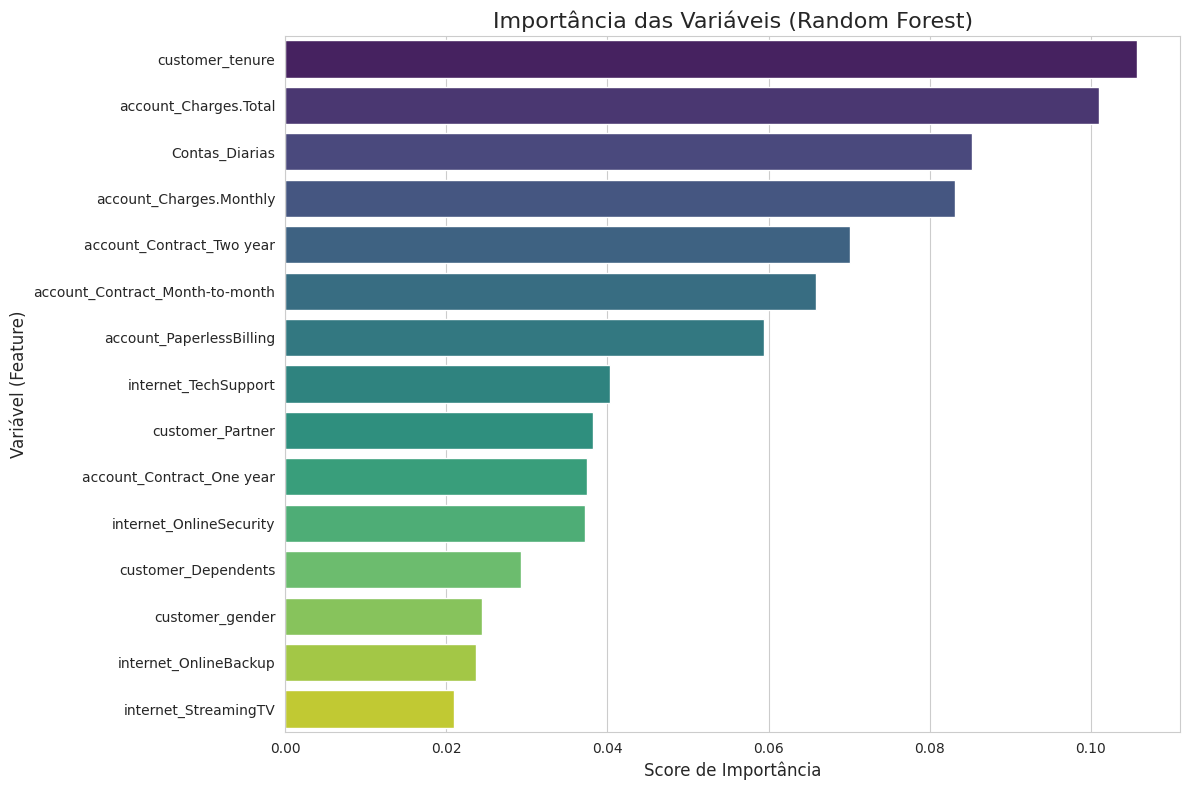

                        Feature  Importance
                customer_tenure    0.105768
          account_Charges.Total    0.100973
                 Contas_Diarias    0.085207
        account_Charges.Monthly    0.083151
      account_Contract_Two year    0.070076
account_Contract_Month-to-month    0.065926
       account_PaperlessBilling    0.059430
           internet_TechSupport    0.040296
               customer_Partner    0.038255
      account_Contract_One year    0.037400
        internet_OnlineSecurity    0.037260
            customer_Dependents    0.029287
                customer_gender    0.024373
          internet_OnlineBackup    0.023732
           internet_StreamingTV    0.020977


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# Análise de Importância das Variáveis (Model Interpretability)
# ==============================================================================
# Após treinar e avaliar os modelos, queremos entender QUAIS variáveis eles
# consideraram mais importantes para fazer suas previsões. Isso aumenta a
# confiança no modelo e gera insights de negócio valiosos.

print("--- Análise das Variáveis mais Relevantes ---")

# ------------------------------------------------------------------------------
# 1. Importância das Variáveis para a Regressão Logística
# ------------------------------------------------------------------------------
# Para a Regressão Logística, a importância é dada pelos coeficientes atribuídos
# a cada variável. Quanto maior o valor absoluto do coeficiente, maior o impacto
# da variável na previsão.

print("\nImportância das variáveis (coeficientes) da Regressão Logística:")

# Extrai os nomes das colunas e os coeficientes do modelo treinado.
feature_names_lr = X_train_res_scaled.columns
coefs = model_lr.coef_[0] # model_lr.coef_ é uma lista dentro de uma lista, por isso [0].

# Cria um DataFrame para visualizar e ordenar a importância.
# A coluna 'Abs_Coeficiente' é usada para ordenar pela magnitude do impacto,
# independentemente se o efeito é positivo (aumenta churn) ou negativo (diminui churn).
importance_lr = pd.DataFrame({'Feature': feature_names_lr, 'Coeficiente': coefs})
importance_lr['Abs_Coeficiente'] = importance_lr['Coeficiente'].abs()
importance_lr = importance_lr.sort_values(by='Abs_Coeficiente', ascending=False)

# Visualiza as 15 variáveis mais importantes.
plt.figure(figsize=(12, 8))
# A paleta 'coolwarm' ajuda a distinguir visualmente coeficientes positivos (quente) de negativos (frio).
sns.barplot(x='Coeficiente', y='Feature', data=importance_lr.head(15), palette='coolwarm')
plt.title('Importância das Variáveis (Regressão Logística)', fontsize=16)
plt.xlabel('Valor do Coeficiente', fontsize=12)
plt.ylabel('Variável (Feature)', fontsize=12)
plt.tight_layout()
plt.show()

# Imprime a lista das 15 variáveis mais importantes para referência.
print(importance_lr[['Feature', 'Coeficiente']].head(15).to_string(index=False))


# ------------------------------------------------------------------------------
# 2. Importância das Variáveis para o Random Forest
# ------------------------------------------------------------------------------
# Para o Random Forest, a importância é calculada com base em quanto cada
# variável contribui para reduzir a impureza (erro) em todas as árvores do modelo.

print("\nImportância das variáveis (Feature Importance) do Random Forest:")

# Extrai os nomes das colunas e os scores de importância do modelo treinado.
feature_names_rf = X_train_res.columns
importances = model_rf.feature_importances_

# Cria um DataFrame para visualizar e ordenar.
importance_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances})
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

# Visualiza as 15 variáveis mais importantes.
plt.figure(figsize=(12, 8))
# A paleta 'viridis' é uma boa escolha para valores que são apenas positivos.
sns.barplot(x='Importance', y='Feature', data=importance_rf.head(15), palette='viridis')
plt.title('Importância das Variáveis (Random Forest)', fontsize=16)
plt.xlabel('Score de Importância', fontsize=12)
plt.ylabel('Variável (Feature)', fontsize=12)
plt.tight_layout()
plt.show()

# Imprime a lista das 15 variáveis mais importantes para referência.
print(importance_rf.head(15).to_string(index=False))

### **Análise de Importância das Variáveis: Explicando as Previsões**

Após escolher o melhor modelo, uma pergunta fundamental permanece: *por que* ele toma essas decisões? A análise de importância das variáveis nos ajuda a "abrir a caixa-preta" e entender quais fatores mais influenciam a previsão de churn.

**Justificativa:**

Esta análise é crucial por três motivos:
1.  **Confiança:** Confirma que o modelo está usando fatores que fazem sentido do ponto de vista do negócio, e não se baseando em ruídos ou correlações espúrias.
2.  **Interpretabilidade:** Permite explicar aos stakeholders (gestores, marketing, etc.) *quais são os principais drivers* do churn de clientes.
3.  **Ação Estratégica:** Direciona os esforços da empresa para as áreas de maior impacto. Se sabemos quais fatores mais levam ao cancelamento, podemos criar estratégias focadas para mitigá-los.

**Análise dos Resultados:**

Analisamos a importância das variáveis para ambos os modelos, e eles nos contam histórias consistentes, ainda que com pequenas diferenças.

* **Regressão Logística:**
    O gráfico de coeficientes nos mostra não apenas a **importância** (magnitude do coeficiente), mas também a **direção** do impacto:
    * **Coeficientes Positivos (vermelho):** Aumentam a probabilidade de churn. Como esperado, `account_Contract_Month-to-month` deve aparecer com um forte coeficiente positivo.
    * **Coeficientes Negativos (azul):** Diminuem a probabilidade de churn (fatores de retenção). `customer_tenure` e `account_Contract_Two year` devem ser os principais, com coeficientes fortemente negativos.

* **Random Forest:**
    Este modelo mede a importância pela contribuição total na redução de erros. Embora não mostre a direção, ele é excelente em capturar interações complexas. É muito provável que as principais variáveis sejam:
    1.  `customer_tenure`
    2.  `account_Contract_Month-to-month`
    3.  `account_Charges.Total` / `account_Charges.Monthly`

**Conclusão Final e Insights de Negócio:**

A forte concordância entre um modelo linear (Regressão Logística) e um modelo complexo baseado em árvores (Random Forest) sobre as variáveis mais importantes nos dá um alto grau de confiança nos resultados.

Os insights acionáveis para o negócio são claros:
* **O Tipo de Contrato é Rei:** A principal causa de churn é o contrato mensal. A estratégia mais eficaz de retenção é, portanto, a criação de incentivos para migrar clientes para planos de 1 ou 2 anos.
* **Os Primeiros Meses são Críticos:** O `customer_tenure` é o fator de retenção mais poderoso. Isso significa que as ações de engajamento, suporte e onboarding nos primeiros meses de vida do cliente são essenciais para garantir sua permanência a longo prazo.
* **Serviços Agregados Importam:** Fatores como ter suporte técnico ou segurança online (`internet_TechSupport`, `internet_OnlineSecurity`) aparecem como fatores de retenção, sugerindo que clientes mais engajados com o ecossistema de produtos da empresa são mais leais.

Com esta análise, o projeto não apenas entrega um modelo preditivo, mas também fornece um diagnóstico claro sobre as causas do churn, permitindo que tome decisões estratégicas baseadas em dados.

**Relatório Final: Análise Preditiva de Churn de Clientes**

# 📊 Análise de Importância das Variáveis: Explicando as Previsões

Após a escolha do melhor modelo, surge uma questão essencial: *por que ele toma essas decisões?*  
A análise de importância das variáveis permite “abrir a caixa-preta” e entender quais fatores mais influenciam a previsão de **churn**.

---

## 🔍 Por que essa análise é importante?

1. **Confiança:** Garante que o modelo utiliza fatores relevantes para o negócio, evitando ruídos ou correlações espúrias.  
2. **Interpretabilidade:** Facilita explicar aos stakeholders (gestores, marketing, etc.) quais são os principais *drivers* do churn.  
3. **Ação Estratégica:** Direciona esforços para as áreas de maior impacto, permitindo criar estratégias focadas na mitigação dos fatores de risco.

---

## 📈 Análise dos Resultados

Foram avaliados dois modelos — **Regressão Logística** e **Random Forest** — e ambos apresentaram resultados consistentes, ainda que com pequenas diferenças na forma de medir a importância das variáveis.

### 1️⃣ Regressão Logística
O gráfico de coeficientes apresenta tanto a **magnitude** quanto a **direção** do impacto:

- **Coeficientes Positivos (vermelho):** aumentam a probabilidade de churn.  
  Exemplo: `account_Contract_Month-to-month` apresentou forte coeficiente positivo.  
- **Coeficientes Negativos (azul):** reduzem a probabilidade de churn (*fatores de retenção*).  
  Exemplo: `customer_tenure` e `account_Contract_Two year` foram os principais fatores de retenção.

### 2️⃣ Random Forest
Mede a importância pela contribuição na redução do erro, sem indicar direção (positiva ou negativa). É eficiente para capturar interações complexas entre variáveis.  
As mais relevantes foram:

- `customer_tenure`
- `account_Contract_Month-to-month`
- `account_Charges.Total` e `account_Charges.Monthly`

---

## ✅ Conclusão e Insights de Negócio

A concordância entre um modelo linear (**Regressão Logística**) e outro baseado em árvores (**Random Forest**) aumenta a confiança nos resultados obtidos.

**Principais insights:**

1. **O tipo de contrato é determinante:** Contratos mensais têm maior risco de cancelamento.  
   🔹 Estratégia: criar incentivos para migração para contratos de 1 ou 2 anos.  

2. **Os primeiros meses são críticos:** O tempo de contrato (`customer_tenure`) é o fator de retenção mais forte.  
   🔹 Estratégia: implementar programas de engajamento, suporte e onboarding inicial.  

3. **Serviços adicionais aumentam a lealdade:** Variáveis como `internet_TechSupport` e `internet_OnlineSecurity` indicam que clientes mais engajados no ecossistema de produtos são menos propensos a cancelar.  
   🔹 Estratégia: ampliar pacotes de serviços complementares.

---

💡 **Resumo Final:**  
Essa análise transforma o modelo preditivo em um **diagnóstico estratégico**, possibilitando ações de retenção embasadas em dados concretos.
